In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

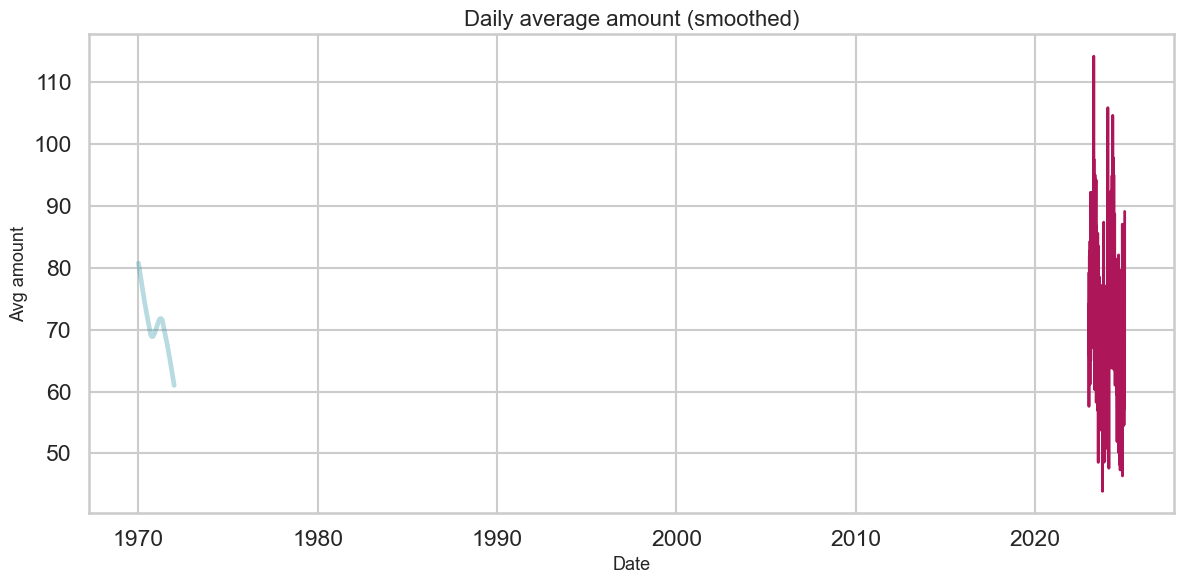

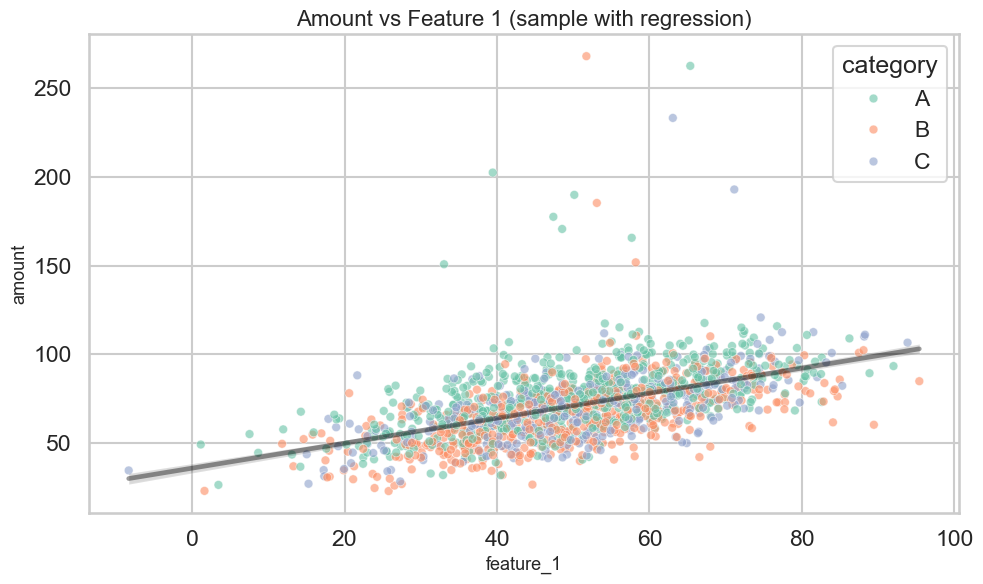

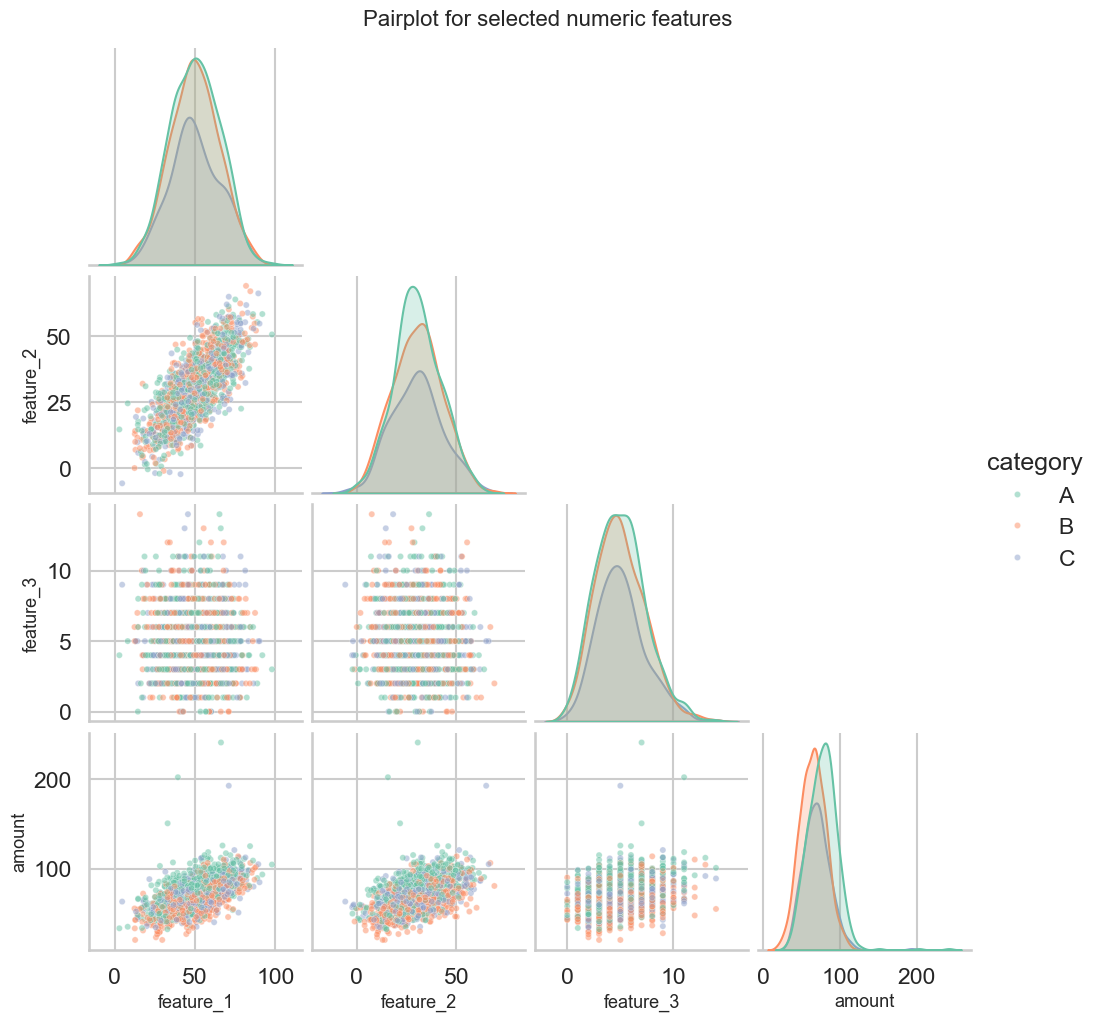

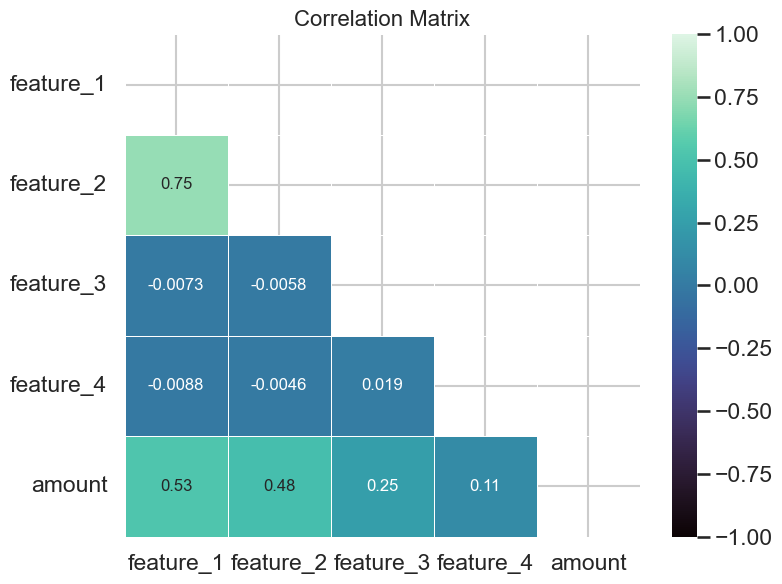

C:\Users\anike\AppData\Local\Temp\ipykernel_27972\2325560503.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="category", y="amount", palette=palettes["qual"], inner=None, alpha=0.85)


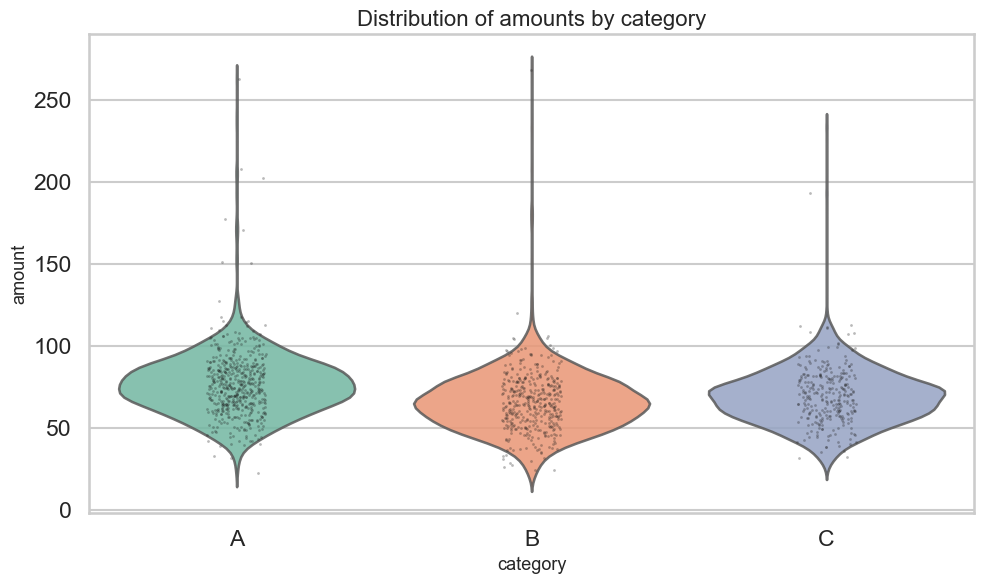

C:\Users\anike\AppData\Local\Temp\ipykernel_27972\2325560503.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="region", y="amount", palette="Set3")


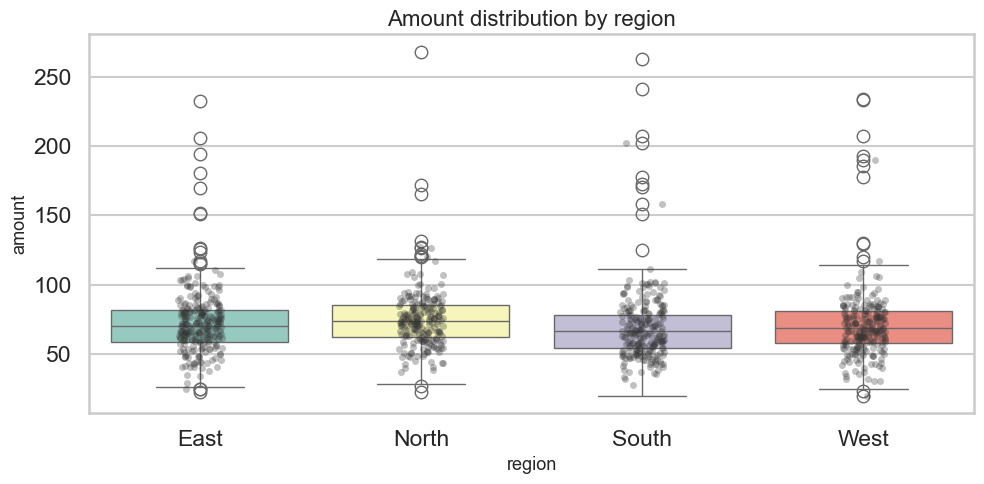

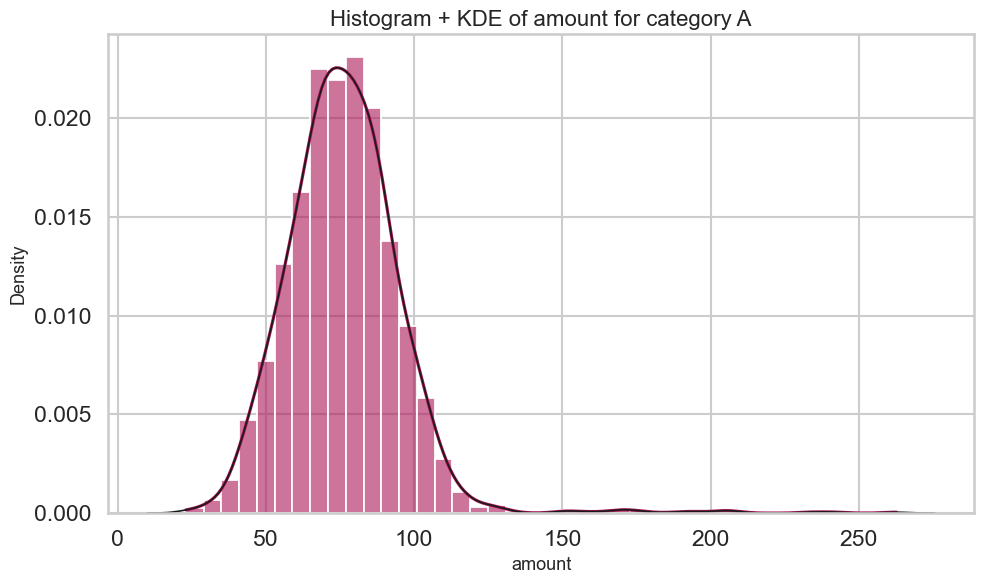

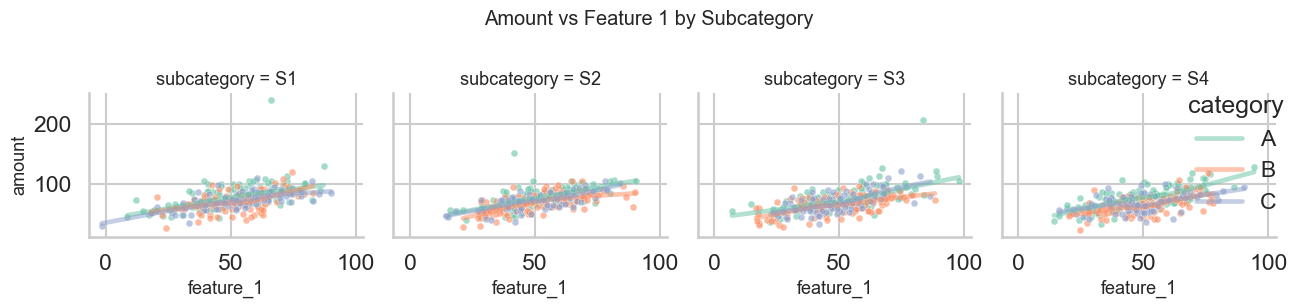

Saved CSV to: examples_output\data\sample_dataset.csv
Saved figures to: examples_output\figures


In [2]:
# ...existing code...
"""
Seaborn demo:
- Generates a medium-sized dataset (default 5k rows)
- Shows how to make a set of beautiful Seaborn plots and saves them to disk
"""

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

def generate_sample_dataset(n=5000, seed=42, start_date="2023-01-01", days=730):
    rng = np.random.default_rng(seed)
    # Create a time base and choose random dates
    dates = pd.date_range(start=start_date, periods=days, freq="D")
    timestamps = rng.choice(dates, size=n)
    
    regions = ["North", "South", "East", "West"]
    categories = ["A", "B", "C"]
    subcats = ["S1", "S2", "S3", "S4"]
    
    df = pd.DataFrame({
        "id": np.arange(1, n+1),
        "timestamp": timestamps,
        "region": rng.choice(regions, size=n),
        "category": rng.choice(categories, size=n, p=[0.4, 0.35, 0.25]),
        "subcategory": rng.choice(subcats, size=n),
    })
    
    # Numeric features with controlled correlation & seasonal pattern
    # base features
    df["feature_1"] = rng.normal(loc=50, scale=15, size=n)
    df["feature_2"] = df["feature_1"] * 0.6 + rng.normal(loc=0, scale=8, size=n)  # correlated
    df["feature_3"] = rng.poisson(lam=5, size=n)  # counts
    df["feature_4"] = rng.exponential(scale=10, size=n)  # skewed positive
    
    # seasonal component for date
    day_of_year = df["timestamp"].dt.dayofyear.values
    seasonal = 10 * np.sin(2 * np.pi * day_of_year / 365.25)
    
    # region and category effect
    region_effect = df["region"].map({"North": 5, "South": -3, "East": 2, "West": 0}).astype(float)
    cat_effect = df["category"].map({"A": 8, "B": -2, "C": 0}).astype(float)
    sub_effect = df["subcategory"].map({"S1": 1, "S2": 2, "S3": -1, "S4": 0}).astype(float)
    
    # Target variable 'amount' with seasonal + features + noise
    df["amount"] = (20 + 0.5 * df["feature_1"] + 0.3 * df["feature_2"] +
                    2.0 * df["feature_3"] + 0.2 * df["feature_4"] +
                    seasonal + region_effect + cat_effect + sub_effect +
                    rng.normal(loc=0, scale=8, size=n))
    
    # Introduce a few outliers
    outlier_idx = rng.choice(df.index, size=max(1, n // 150), replace=False)
    df.loc[outlier_idx, "amount"] *= rng.uniform(1.5, 3.5, size=len(outlier_idx))
    
    # binary flag for demonstration
    df["is_high"] = (df["amount"] > df["amount"].quantile(0.85)).astype(int)
    # simple categorical label
    df["label"] = (df["category"] + "_" + df["subcategory"]).astype(str)
    
    # ensure types are compact
    df = df.astype({"id": int, "region": "category", "category": "category", "subcategory": "category", "label": "category"})
    return df

def save_df_and_create_dirs(df, base_dir="examples_output"):
    base = Path(base_dir)
    base.mkdir(parents=True, exist_ok=True)
    data_dir = base / "data"
    fig_dir = base / "figures"
    data_dir.mkdir(parents=True, exist_ok=True)
    fig_dir.mkdir(parents=True, exist_ok=True)
    csvfile = data_dir / "sample_dataset.csv"
    df.to_csv(csvfile, index=False)
    return base, data_dir, fig_dir

def pretty_settings():
    sns.set_theme(style="whitegrid")
    sns.set_context("talk", rc={"font.size": 12, "axes.titlesize": 16, "axes.labelsize": 13})
    # color ramp for a pleasing set of palettes
    palettes = {
        "quant": "rocket",
        "div": "vlag",
        "qual": "Set2",
        "cmap": sns.color_palette("mako", as_cmap=True)
    }
    return palettes

def plot_examples(df, fig_dir, palettes):
    # 1) Time series: daily aggregate with smoothed line and shading
    plt.figure(figsize=(12, 6))
    ts = df.groupby("timestamp")["amount"].mean().sort_index()
    sns.lineplot(x=ts.index, y=ts.values, color=sns.color_palette(palettes["quant"])[2], linewidth=2.0)
    sns.regplot(x=np.arange(len(ts)), y=ts.values, scatter=False, lowess=True,
                color=sns.color_palette("mako", 4)[2], line_kws={"alpha": 0.35})
    plt.title("Daily average amount (smoothed)")
    plt.xlabel("Date")
    plt.ylabel("Avg amount")
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_dir / "time_series_avg_amount.png", dpi=150)
    plt.close()
    
    # 2) Scatter + regression by category
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df.sample(1500, random_state=1), x="feature_1", y="amount",
                    hue="category", palette=palettes["qual"], alpha=0.6, s=40)
    sns.regplot(data=df.sample(1500, random_state=1), x="feature_1", y="amount",
                scatter=False, color="black", line_kws={"alpha": 0.4})
    plt.title("Amount vs Feature 1 (sample with regression)")
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_dir / "scatter_reg_feature1_amount.png", dpi=150)
    plt.close()
    
    # 3) Pairplot of numeric features by category (moderate sampling)
    pair_sample = df.sample(min(1500, len(df)), random_state=2)
    pairplot = sns.pairplot(pair_sample, vars=["feature_1", "feature_2", "feature_3", "amount"],
                            hue="category", palette=palettes["qual"], corner=True, plot_kws={"alpha": 0.5, "s": 20})
    pairplot.fig.suptitle("Pairplot for selected numeric features", y=1.02, fontsize=16)
    pairplot.savefig(fig_dir / "pairplot_numeric_features.png", dpi=150)
    plt.show()
    plt.close()
    
    # 4) Correlation matrix heatmap
    plt.figure(figsize=(8, 6))
    corr = df[["feature_1", "feature_2", "feature_3", "feature_4", "amount"]].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap=palettes["cmap"], vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_dir / "correlation_heatmap.png", dpi=150)
    plt.close()
    
    # 5) Violin + swarm by category
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x="category", y="amount", palette=palettes["qual"], inner=None, alpha=0.85)
    sns.stripplot(data=df.sample(1200, random_state=3), x="category", y="amount", color="k", size=2, alpha=0.3)
    plt.title("Distribution of amounts by category")
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_dir / "violin_amount_by_category.png", dpi=150)
    plt.close()
    
    # 6) Boxplot across region + scatter overlay
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x="region", y="amount", palette="Set3")
    sns.stripplot(data=df.sample(900, random_state=10), x="region", y="amount", color=".2", alpha=0.3)
    plt.title("Amount distribution by region")
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_dir / "box_amount_by_region.png", dpi=150)
    plt.close()
    
    # 7) KDE + histogram for a single category
    subset = df[df["category"] == "A"]
    plt.figure(figsize=(10, 6))
    sns.histplot(subset["amount"], kde=True, color=sns.color_palette("rocket")[2], stat="density", bins=40, alpha=0.6)
    sns.kdeplot(subset["amount"], color="k", linewidth=1.2)
    plt.title("Histogram + KDE of amount for category A")
    plt.tight_layout()
    plt.show()
    plt.savefig(fig_dir / "hist_kde_amount_catA.png", dpi=150)
    plt.close()
    
    # 8) FacetGrid: amount vs feature_1 across subcategories
    g = sns.FacetGrid(df.sample(min(1200, len(df)), random_state=4), col="subcategory", hue="category",
                      col_wrap=4, height=3, palette=palettes["qual"], despine=True)
    g.map_dataframe(sns.scatterplot, x="feature_1", y="amount", alpha=0.6, s=25)
    g.map_dataframe(sns.regplot, x="feature_1", y="amount", scatter=False, lowess=True, line_kws={"alpha": 0.5})
    g.add_legend()
    g.fig.suptitle("Amount vs Feature 1 by Subcategory", y=1.02)
    plt.tight_layout()
    plt.show()
    g.savefig(fig_dir / "facet_amount_feature1_subcat.png", dpi=150)
    plt.close()
    
    # 9) Jointplot: hex density between feature_2 and amount
    jp = sns.jointplot(data=df.sample(1000, random_state=5), x="feature_2", y="amount", kind="hex", cmap="rocket")
    jp.fig.suptitle("Hex-density between feature_2 and amount", y=1.02)
    jp.fig.tight_layout()
    jp.savefig(fig_dir / "jointplot_feature2_amount_hex.png", dpi=150)
    plt.close()

def main():
    df = generate_sample_dataset(n=5000, seed=42)
    base, data_dir, fig_dir = save_df_and_create_dirs(df, base_dir="examples_output")
    palettes = pretty_settings()
    plot_examples(df, fig_dir, palettes)
    print(f"Saved CSV to: {data_dir / 'sample_dataset.csv'}")
    print(f"Saved figures to: {fig_dir}")

if __name__ == "__main__":
    main()
# ...existing code...